# NBODYKIT mock catalogs

This notebook has a lot of routines that were used as test for the routines later used in the main research. Procceed with caution as it is very very messy

In [1]:
from nbodykit.lab import *
from fastpm.nbkit import FastPMCatalogSource
import numpy as np
import dask.array as da
import scipy.ndimage
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

In [2]:
# Global Parameters
Nc = 128
Length = 500 # Mpc  h-1
zobs = 0.3
zinit = 3.
r_s = 10. # smoothing radius

# Setup initial conditions
cosmo = cosmology.Planck15

# Generate IC density field
power = cosmology.LinearPower(cosmo, redshift=zobs)
linear = LinearMesh(power, BoxSize=Length, Nmesh=Nc)

# Or load from file
# linear = BigFileMesh('linear_ic_mesh.bigfile', dataset='Field')

# P(k) of initial field
r = FFTPower(linear, mode="1d")
Pklin = r.power['power'].real
k = r.power['k']
mask = (k <= 0.09)*(k > 0.03)

/home/pcontreras/anaconda3/lib/python3.8/site-packages/nbodykit/source/mesh/linear.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  mask = numpy.bitwise_and.reduce([ki == 0 for ki in k])


In [3]:
# Plin = cosmology.LinearPower(cosmo, 0)
# linear = LinearMesh(Plin, BoxSize=Length, Nmesh=Nc, seed=42)
# r = FFTPower(linear, mode="1d")
# Plin0 = r.power['power'].real

In [3]:
# Run the FastPM particle mesh simulation
matter = FastPMCatalogSource(linear, Nsteps=10)

# Or load from file
# matter = BigFileCatalog('fastpm_dmcatalog.bigfile')

In [30]:
matter.save('fastpm_dmcatalog.bigfile')

In [ ]:
cellsize = Length/Nc

# Compute matter density field
delta_dm = matter.to_mesh(resampler='cic', interlaced=True, compensated=True)

# Compute and save matter P(k,z)
r = FFTPower(delta_dm, mode="1d")
r.save('P_NL.json')
# shot-noise from nbodykit
Pkdm = r.power['power'].real - r.power.attrs['shotnoise']
ndm = matter.csize

In [35]:
delta_dm.save('NL_mesh')

Text(0.5, 1.0, 'Dark Matter, $1316.25 \\leq z < 1755$ Mpc h$^{-1}$')

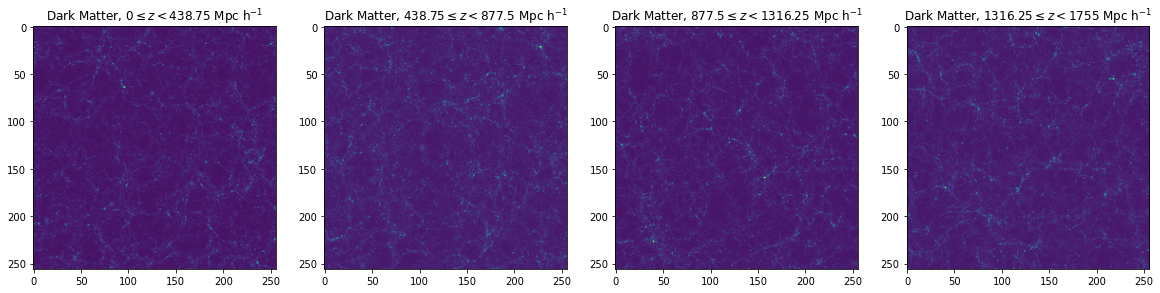

In [8]:
fig, ax = plt.subplots(1, 4, figsize=(20, 5))

oneplusdeltadm = delta_dm.paint(mode='real')

ax[0].imshow(np.sum(oneplusdeltadm[:,:,:64], axis=2))
ax[0].set_title(r'Dark Matter, $0 \leq z < 438.75$ Mpc h$^{-1}$')#r'$1 + \delta_{g}$')
ax[1].imshow(np.sum(oneplusdeltadm[:,:,64:128], axis=2))
ax[1].set_title(r'Dark Matter, $438.75 \leq z < 877.5$ Mpc h$^{-1}$')#r'$1 + \delta_{g}$')
ax[2].imshow(np.sum(oneplusdeltadm[:,:,128:192], axis=2))
ax[2].set_title(r'Dark Matter, $877.5 \leq z < 1316.25$ Mpc h$^{-1}$')#r'$1 + \delta_{g}$')
ax[3].imshow(np.sum(oneplusdeltadm[:,:,192:], axis=2))
ax[3].set_title(r'Dark Matter, $1316.25 \leq z < 1755$ Mpc h$^{-1}$')#r'$1 + \delta_{g}$')

In [26]:
# Run FOF to identify halo groups
# fof = FOF(matter, linking_length=0.4*cellsize, nmin=20, absolute=True)
fof = FOF(matter, linking_length=0.4, nmin=1)

# DM particle mass
# h = cosmology.Planck15.h
# Omega_M = cosmology.Planck15.Omega0_cdm + cosmology.Planck15.Omega0_b
# H0Mpc = 100.0*h*(3.24078e-20)
# GMsunMpcS = 4.5182422e-48
# rhomean = (3.0/(8.0*np.pi*GMsunMpcS))*Omega_M*(H0Mpc**2)
# Mdm = rhomean*((Length*h)**3)
# DM_part_mass = Mdm/ndm

DM_part_mass = .5e12
halos = fof.to_halos(cosmo=cosmo, redshift=zobs, particle_mass=DM_part_mass, mdef='vir')

In [ ]:
halos.save('halos_catalogue.bigfile')

In [10]:
halo_dat = np.zeros((halos.csize, 7))
halo_dat[:,:3] = halos['Position'].compute()
halo_dat[:,3:6] = halos['Velocity'].compute()
halo_dat[:,6] = halos['Mass'].compute()

mat = np.matrix(halo_dat)
with open('halo_cat_pre_z03.dat', 'wb') as ff:
    for line in mat:
        np.savetxt(ff, line, fmt='%.7e')

In [27]:
nhalos = halos.csize
delta_halos = halos.to_mesh(resampler='cic', interlaced=True, compensated=True)
r = FFTPower(delta_halos, mode="1d", Nmesh=Nc)

# shot-noise from nbodykit
Pkhalos = r.power['power'].real - r.attrs['shotnoise']
print('Halo number density = {:.3e}'.format(nhalos/(Length**3)))

Halo number density = 8.273e-04


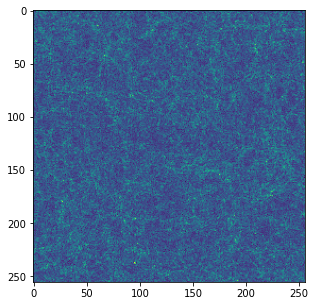

In [9]:
fig = plt.figure(figsize=(5, 5))
plt.imshow(delta_halos.paint(mode='real').preview(axes=[0,1]))

In [6]:
# Populate halos with galaxies
hod = halos.populate(Zheng07Model)

# Load galaxy catalog from file
# hod = BigFileCatalog('hod_gcatalog.bigfile')

# Compute galaxy density field
delta_g = hod.to_mesh(resampler='cic', interlaced=True, compensated=True)

# Compute and save galaxy P(k,z)
r = FFTPower(delta_g, mode="1d", Nmesh=Nc)

# shot-noise from nbodykit
Pkg = r.power['power'].real - r.attrs['shotnoise']
ngal = hod.csize

print('Galaxy number density = {:.3e}'.format(ngal/(Length**3)))

Galaxy number density = 7.242e-05


Text(0.5, 1.0, 'Galaxy, $1316.25 \\leq z < 1755$ Mpc h$^{-1}$')

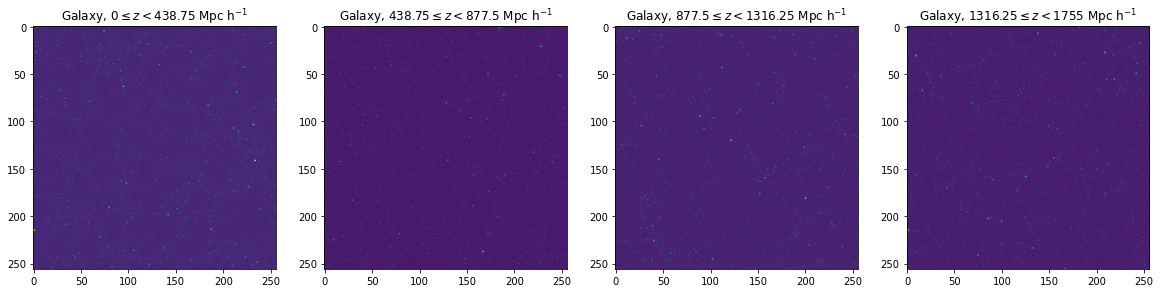

In [12]:
fig, ax = plt.subplots(1, 4, figsize=(20, 5))

oneplusdeltag = delta_g.paint(mode='real')

ax[0].imshow(np.sum(oneplusdeltag[:,:,:64], axis=2))
ax[0].set_title(r'Galaxy, $0 \leq z < 438.75$ Mpc h$^{-1}$')#r'$1 + \delta_{g}$')
ax[1].imshow(np.sum(oneplusdeltag[:,:,64:128], axis=2))
ax[1].set_title(r'Galaxy, $438.75 \leq z < 877.5$ Mpc h$^{-1}$')#r'$1 + \delta_{g}$')
ax[2].imshow(np.sum(oneplusdeltag[:,:,128:192], axis=2))
ax[2].set_title(r'Galaxy, $877.5 \leq z < 1316.25$ Mpc h$^{-1}$')#r'$1 + \delta_{g}$')
ax[3].imshow(np.sum(oneplusdeltag[:,:,192:], axis=2))
ax[3].set_title(r'Galaxy, $1316.25 \leq z < 1755$ Mpc h$^{-1}$')#r'$1 + \delta_{g}$')

In [13]:
# Save catalog pre-reconstruction celestial coordinates
hod['SkyCoordz'] = transform.CartesianToSky(pos=hod['Position'], cosmo=cosmo, \
    observer=da.from_array([Length/2,Length/2,Length/2]), zmax=100., frame='icrs')
hod['SkyCoordzpec'] = transform.CartesianToSky(pos=hod['Position'], cosmo=cosmo, velocity=hod['Velocity'], \
    observer=da.from_array([Length/2,Length/2,Length/2]), zmax=100., frame='icrs')

coord_array = np.zeros((ngal, 4))
coord_array[:, 0:3] = hod['SkyCoordz'].compute()
coord_array[:, 3] = hod['SkyCoordzpec'][:,2].compute()
mat = np.matrix(coord_array)
with open('cat_pre_z0.dat', 'wb') as ff:
    for line in mat:
        np.savetxt(ff, line, fmt='%.2f')

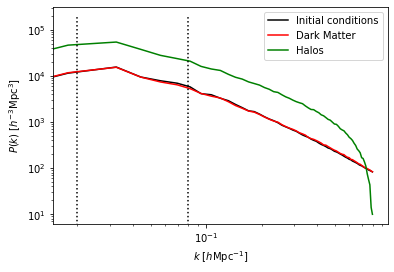

In [28]:
# Visualizes Pk's
# plt.loglog(k, power.__call__(k), label='Theoric')
plt.loglog(k, Pklin, 'k', label='Initial conditions')
plt.loglog(k, Pkdm, 'r', label='Dark Matter')
plt.loglog(k, Pkhalos, 'g', label='Halos')
plt.vlines(0.02, np.min(Pkdm), np.max(Pkg)+50, 'k', linestyle='dotted')
plt.vlines(0.08, np.min(Pkdm), np.max(Pkg)+50, 'k', linestyle='dotted')
plt.xlabel(r'$k$ $[h \mathrm{Mpc}^{-1}]$')
plt.ylabel(r'$P(k)$ $[h^{-3} \mathrm{Mpc}^3]$')
plt.legend()

In [15]:
# Root mean square of velocity of galaxies
# velocity = hod['Velocity'].compute()
# velocities_sqr = (np.linalg.norm(velocity, axis=1))**2
# v_rms = np.sqrt(np.sum(velocities_sqr)/ngal)
# print(v_rms)

## Moving to Redshift Space

In [8]:
## RSD formula
# vr = 1/(Ha) * (vec(v).vec(r_unit))vec(r_unit)
# 
## Box centered
position_origin = hod['Position'] - 0.5*Length

projection_norm = np.linalg.norm(position_origin, axis=1)

line_of_sight = np.zeros_like(position_origin)
line_of_sight = position_origin/projection_norm[:, np.newaxis]

rsd_factor = (1+zobs) / (100 * cosmo.efunc(zobs))

dot_prod = np.sum(hod['Velocity']*line_of_sight, axis=1)

hod['PositionRSD'] = position_origin + rsd_factor*dot_prod[:, np.newaxis]*line_of_sight + 0.5*Length

## Flat Sky
# hod['PositionRSD'] = hod['Position'] + transform.VectorProjection(hod['VelocityOffset'],[0,0,1])

In [9]:
delta_gRSD = hod.to_mesh(resampler='cic', position='PositionRSD', interlaced=True, compensated=True)
r = FFTPower(delta_gRSD, mode='1d', Nmesh=Nc)
PkgRSD = r.power['power'].real - r.attrs['shotnoise']

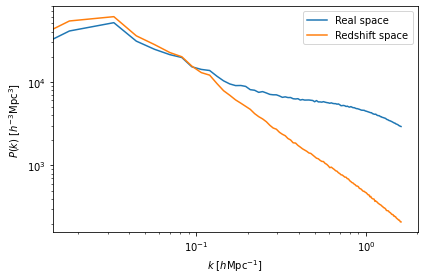

In [10]:
# Compare Pk's in physical and redshift space
plt.loglog(k, Pkg, label='Real space')
plt.loglog(k, PkgRSD, label='Redshift space')
plt.legend()
plt.xlabel(r'$k$ $[h \mathrm{Mpc}^{-1}]$')
plt.ylabel(r'$P(k)$ $[h^{-3} \mathrm{Mpc}^3]$')
# plt.ylim(3e3, 2e5)
plt.tight_layout()
# plt.savefig('rsd_pk.pdf')

Text(0.5, 1.0, 'Redshift space')

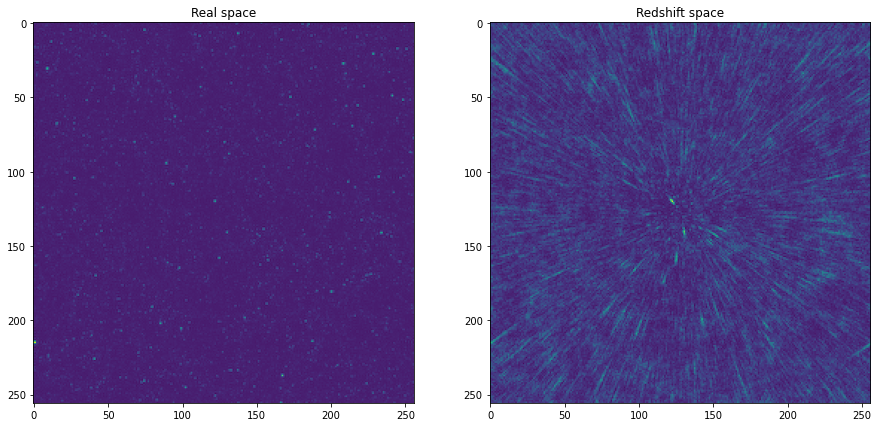

In [19]:
# Compare densifty field in physical and redshift space
fig, ax = plt.subplots(1, 2, figsize=(15, 7))

ax[0].imshow(delta_g.paint(mode='real').preview(axes=[0,1]))
ax[0].set_title('Real space')#r'$1 + \delta_{g}$')

ax[1].imshow(delta_gRSD.paint(mode='real').preview(axes=[0,1]))
ax[1].set_title('Redshift space')#r'$1 + \delta_{g}^{s}$')

### Obtaining bias

In [11]:
bg = np.mean(np.sqrt(Pkg[mask]/Pklin[mask]))

# Another method
# dm_corr = FFTCorr(delta_dm, mode='1d')
# g_corr = FFTCorr(delta_g, mode='1d')
# bg1 = np.nanmean((g_corr.corr['corr']/dm_corr.corr['corr'])**(0.5))

# Another one
# bg2  = np.mean(np.sqrt(Pkg[mask]/(D(zobs)**2 * Plin0[mask])))

print('bias = {:.2f}'.format(bg))

bias = 1.79


### Gaussian Smoothing

In [8]:
def divide_bias(x, v):
    return v/bg

# delta_g_b = delta_gRSD.apply(divide_bias, mode='real', kind='index')

# delta_dm_tilde = delta_g_b.apply(filters.Gaussian(r=r_s).filter, mode='complex', kind='wavenumber')

Text(0.5, 1.0, 'Dark matter proxy')

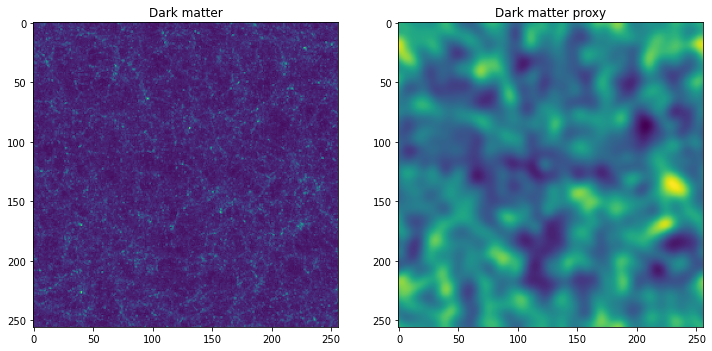

In [22]:
# Compare DM density field with inferred DM density field and galaxy
# density field
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
# ax[0].imshow(linear.paint(mode='real').preview(axes=[0,1]))
# ax[0].set_title('Linear field')

ax[0].imshow(delta_dm.paint(mode='real').preview(axes=[0,1]))
ax[0].set_title('Dark matter')

ax[1].imshow(delta_dm_tilde.paint(mode='real').preview(axes=[0,1]))
ax[1].set_title('Dark matter proxy')

Text(0, 0.5, '$P(k)$ $[h^{-3} \\mathrm{Mpc}^3]$')

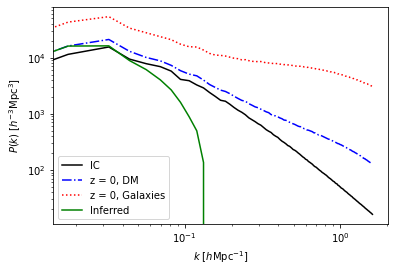

In [23]:
# Compute inferred P(k)
r = FFTPower(delta_dm_tilde, mode='1d', Nmesh=Nc)
Pktilde = r.power['power'].real - r.power.attrs['shotnoise']

# Compare their Pk's
plt.loglog(k, Pklin, 'k', label = 'IC')
plt.loglog(k, Pkdm, '-.b', label = 'z = 0, DM')
plt.loglog(k, Pkg, ':r', label = 'z = 0, Galaxies')
plt.loglog(k, Pktilde, 'g', label = 'Inferred')
plt.legend()
plt.xlabel(r'$k$ $[h \mathrm{Mpc}^{-1}]$')
plt.ylabel(r'$P(k)$ $[h^{-3} \mathrm{Mpc}^3]$')

# Displacement Field and Reconstruction

In [9]:
def fft(inarr):
    finarr= np.fft.fftn(inarr)
    return(finarr)

def ifft(finarr):
    inarr= np.fft.ifftn(finarr)
    return(inarr)

def compute_zeld(L, nc, delta):
    '''
    Obtain displacement field under Zeldovich approximation
    '''
    
    deltaf = fft(delta)

    vfx = deltaf.copy()
    vfy = deltaf.copy()
    vfz = deltaf.copy()
    
    kfac = 2.0*np.pi/L
    
    for i in range(nc):
        for j in range(nc):
            for k in range(nc):

                if i <= nc/2:
                    kx = kfac*np.float64(i)
                else:
                    kx = -kfac*np.float64(nc-i)
                if j <= nc/2:
                    ky = kfac*np.float64(j)
                else:
                    ky = -kfac*np.float64(nc-j)
                if k <= nc/2:
                    kz = kfac*np.float64(k)
                else:
                    kz = -kfac*np.float64(nc-k)

                k2 = kx**2 + ky**2 + kz**2

                kernelx = 0.
                kernely = 0.
                kernelz = 0.


    # kernel: -nabla/nabla2 = i*kvec/k2 viene de: 
    # d(exp(i*kvec*r))/dr=i*kvec  , d(exp(i*kvec*r))2/dr2=(i*kvec)*(i*kvec)=-k2 

                epsk = 1e-14
                if k2>epsk:
                    kernelx = kx/k2
                    kernely = ky/k2
                    kernelz = kz/k2
                
                vfx.real[i,j,k] = -kernelx*deltaf.imag[i,j,k]
                vfx.imag[i,j,k] =  kernelx*deltaf.real[i,j,k]

                vfy.real[i,j,k] = -kernely*deltaf.imag[i,j,k]
                vfy.imag[i,j,k] =  kernely*deltaf.real[i,j,k]

                vfz.real[i,j,k] = -kernelz*deltaf.imag[i,j,k]
                vfz.imag[i,j,k] =  kernelz*deltaf.real[i,j,k]

    vxg = ifft(vfx)
    vx = vxg.real
    
    vyg = ifft(vfy)
    vy = vyg.real

    vzg = ifft(vfz)
    vz = vzg.real

    vel1D = np.zeros(nc**3 * 3)
    psi   = vel1D.reshape(nc,nc,nc,3)

    psi[:,:,:,0] = vx
    psi[:,:,:,1] = vy
    psi[:,:,:,2] = vz


    return psi

In [10]:
#work to do
def D(z):
    '''
    Obtain growth factor
    '''
    return cosmology.background.MatterDominated(cosmology.Planck15.Omega0_m).D1(1/(1+z))

def f(z):
    '''
    Obtain growth rate
    '''
    return cosmology.background.MatterDominated(cosmology.Planck15.Omega0_m).f1(1/(1+z))

def displace_galaxies(psi, posg, nc, boxsize, zinit, zobs):
    '''
    Reconstruction to a given redshift given a displacement field
    '''
    # objetivo es llevar las galaxias de zobs a zinit

    # tamano celda
    cellsize = boxsize/nc
    # interpolamos el campo de velocidad en la malla a la posición de la galaxia
    psi_g = np.zeros_like(posg)

    for i in range(len(psi_g)):
        j = int(np.floor(posg[i, 0]/cellsize))
        k = int(np.floor(posg[i, 1]/cellsize))
        l = int(np.floor(posg[i, 2]/cellsize))

        j = int(np.fmod(j,nc))
        k = int(np.fmod(k,nc))
        l = int(np.fmod(l,nc))

        psi_g[i, 0] = psi[j, k, l, 0]
        psi_g[i, 1] = psi[j, k, l, 1]
        psi_g[i, 2] = psi[j, k, l, 2]
    
    # calculamos los growth factors
    # Psi(q) está normalizado a D(z=0), por tanto si me voy a z=0 desde zinfty:
    # r(z=0)=q+Psi(q)

    # r(zobs)=q+D(zobs)*Psi(q)
    # r(zinit)=q+D(zinit)*Psi(q)

    # Entonces, para ir de zobs a zinit:
    # r(zinit)=r(zobs)-(D(zobs)-D(zinit))*Psi(q)

    posp = posg - (D(zobs) - D(zinit))*psi_g
       
    return posp

In [15]:
psi = compute_zeld(Length, Nc, delta_dm_tilde.paint(mode='real'))

In [27]:
# maximum and minimum of displacement field
# print(psi.min(), psi.max(), psi.std())

In [16]:
hod['Position_zinit'] = displace_galaxies(psi, hod['PositionRSD'].compute(), Nc, Length, zinit=zinit, zobs=zobs)
delta_gzinit = hod.to_mesh(position='Position_zinit', resampler='cic', interlaced=True, compensated=True)

Text(0.5, 1.0, 'Post-reconstruction')

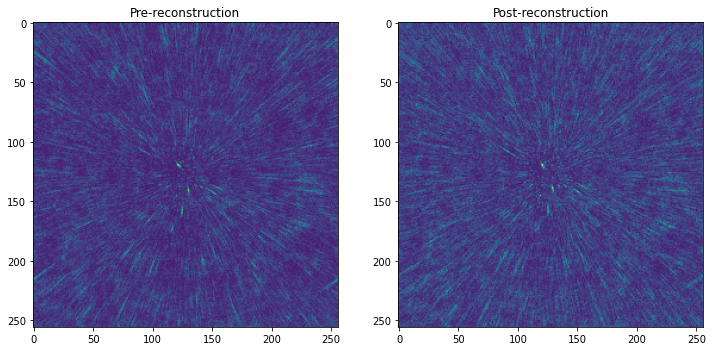

In [29]:
# density field at zinit
fig, ax = plt.subplots(1,2,figsize=(12, 6))
# ax[0].imshow(delta_dm.paint(mode='real').preview(axes=[0,1]))
# ax[0].set_title('Dark Matter')
ax[0].imshow(delta_gRSD.paint(mode='real').preview(axes=[0,1]))
ax[0].set_title('Pre-reconstruction')
ax[1].imshow(delta_gzinit.paint(mode='real').preview(axes=[0,1]))
ax[1].set_title('Post-reconstruction')
# plt.savefig('reconstruction.pdf')

## Reconstruction Tests

### Power Spectra

Text(0, 0.5, '$P(k, z)$ $[h^{-3} \\mathrm{Mpc}^3]$')

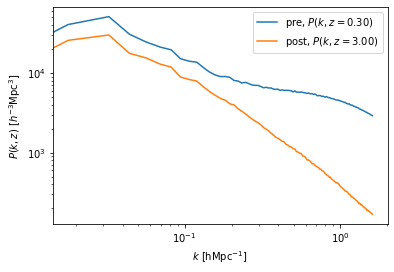

In [17]:
r = FFTPower(delta_gzinit, mode='1d', Nmesh=Nc)
Pkgzinit = r.power['power'].real - r.attrs['shotnoise']

plt.loglog(k, Pkg, label=r'pre, $P(k, z={:.2f})$'.format(zobs))
plt.loglog(k, Pkgzinit, label=r'post, $P(k, z={:.2f})$'.format(zinit))
plt.legend()
plt.xlabel(r'$k\ [\mathrm{h Mpc}^{-1}]$')
plt.ylabel(r'$P(k, z)$ $[h^{-3} \mathrm{Mpc}^3]$')

In [31]:
# Multipoles (monopole and quadrupole) pre-reconstruction
# compute the 2D power AND ell=0,2,4 multipoles
r = FFTPower(delta_g, mode='2d', dk=0.005, kmin=0.005, Nmu=5, los=[0,0,1], poles=[0,2,4])
poles_pre = r.poles

# Post reconstruction
r = FFTPower(delta_gzinit, mode='2d', dk=0.005, kmin=0.005, Nmu=5, los=[0,0,1], poles=[0,2,4])
poles_post = r.poles

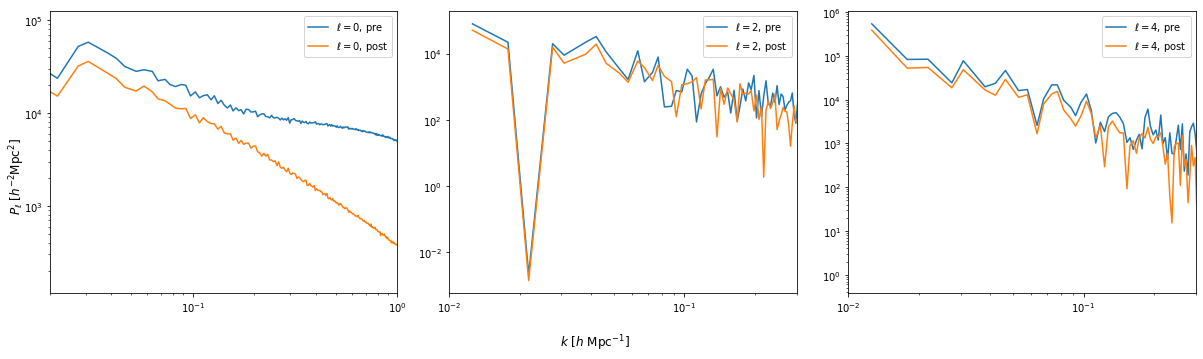

In [32]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(17, 5))

for ell in [0,2,4]:
    label = r'$\ell=%d$' % (ell)
    P_pre = poles_pre['power_%d' %ell].real
    P_post = poles_post['power_%d' %ell].real
    if ell == 0: 
        P_pre = P_pre - poles_pre.attrs['shotnoise']
        P_post = P_post - poles_post.attrs['shotnoise']
        ax1.loglog(poles_pre['k'], P_pre, label=label+', pre')#poles['k'] * 
        ax1.loglog(poles_post['k'], P_post, label=label+', post')#poles['k'] * 
    elif ell == 2.:
        ax2.loglog(poles_pre['k'], abs(P_pre), label=label+', pre')#poles['k'] * 
        ax2.loglog(poles_post['k'], abs(P_post), label=label+', post')#poles['k'] * 
    elif ell == 4.:
        ax3.loglog(poles_pre['k'], abs(P_pre), label=label+', pre')#poles['k'] * 
        ax3.loglog(poles_post['k'], abs(P_post), label=label+', post')#poles['k'] * 
        
# format the axes
ax1.legend(loc=0)
ax1.set(xlim=(0.01, 0.3))#, xscale='log')
ax2.legend(loc=0)
ax2.set(xlim=(0.01, 0.3))#, xscale='log')
ax3.legend(loc=0)
ax3.set(xlim=(0.01, 0.3))#, xscale='log')
fig.supxlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]")
fig.supylabel(r"$P_\ell$ [$h^{-2} \mathrm{Mpc}^2$]")
#ax.set(xlabel=r"$k$ [$h \ \mathrm{Mpc}^{-1}$]", ylabel=r"$k \ P_\ell$ [$h^{-2} \mathrm{Mpc}^2$]")
ax1.set(xlim=(0.02, 1))#, ylim=(-5000, 10000))

plt.tight_layout()
# plt.savefig('Pk_multipoles.pdf')

In [33]:
# fig, (ax1, ax2) = plt.subplots(2,1, figsize=(8, 7), sharex='all')#, gridspec_kw={'height_ratios': [3, 1]})

# for ell in [0,2]:
#     label = r'$\ell=%d$' % (ell)
#     P_pre = poles_pre['power_%d' %ell].real
#     P_post = poles_post['power_%d' %ell].real
#     if ell == 0: 
#         P_pre = P_pre - poles_pre.attrs['shotnoise']
#         up_pre = abs(P_pre)
#         P_post = P_post - poles_pre.attrs['shotnoise']
#         up_post = abs(P_post)
#         ax1.loglog(poles_pre['k'], P_pre, label=label+', pre')#poles['k'] * 
#         ax1.loglog(poles_post['k'], P_post, '-.', label=label+', post')#poles['k'] * 
#     elif ell == 2.:
#         ax1.loglog(poles_pre['k'], abs(P_pre), label=label+', pre')#poles['k'] * 
#         low_pre = abs(P_pre)
#         ax1.loglog(poles_post['k'], abs(P_post), '-.', label=label+', post')#poles['k'] *
#         low_post = abs(P_post)
# ratio_pre = up_pre/low_pre
# ratio_post = up_post/low_post
# ax2.loglog(poles_pre['k'], ratio_pre, label='pre')
# ax2.loglog(poles_pre['k'], ratio_post, '-.',label='post')
    
        
# # format the axes
# ax1.legend(loc=0)
# ax1.set(xlim=(0.01, 0.3))#, xscale='log')
# ax1.set(ylabel=r'$P_\ell$ [$h^{-3} \mathrm{Mpc}^3$]')
# ax2.legend(loc=0)
# ax2.set(ylim=(1,1000))
# ax2.set(xlabel=r'$k$ [$h \ \mathrm{Mpc}^{-1}$]', ylabel=r'$P_{\ell=0}/P_{\ell=2}$')
# fig.subplots_adjust(hspace=0)
# plt.savefig('Pk_ratio_l0l2.pdf')

[Text(0.5, 0, '$k$ [$h \\ \\mathrm{Mpc}^{-1}$]'),
 Text(0, 0.5, '$P_\\ell(\\mathrm{pre})/P_\\ell(\\mathrm{post})$')]

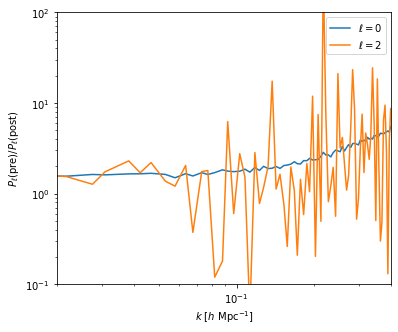

In [34]:
fig, (ax1) = plt.subplots(1,1, figsize=(6, 5))#, sharex='all')#, gridspec_kw={'height_ratios': [3, 1]})

for ell in [0,2]:
    label = r'$\ell=%d$' % (ell)
    P_pre = poles_pre['power_%d' %ell].real
    P_post = poles_post['power_%d' %ell].real
    if ell == 0: 
        P_pre = P_pre - poles_pre.attrs['shotnoise']
        P_post = P_post - poles_pre.attrs['shotnoise']
        ax1.loglog(poles_pre['k'], P_pre/P_post, label=label)#poles['k'] * 
    elif ell == 2.:
        ax1.loglog(poles_post['k'], abs(P_pre/P_post), label=label)#poles['k'] *
        
# format the axes
ax1.legend(loc=0)
ax1.set(xlim=(0.02, 0.4), ylim=(1e-1, 1e2))#, xscale='log')
ax1.set(xlabel=r'$k$ [$h \ \mathrm{Mpc}^{-1}$]', ylabel=r'$P_\ell(\mathrm{pre})/P_\ell(\mathrm{post})$')
# plt.savefig('Pk_ratio_prepost.pdf')

### Velocity field

Text(0, 0.5, 'PDF')

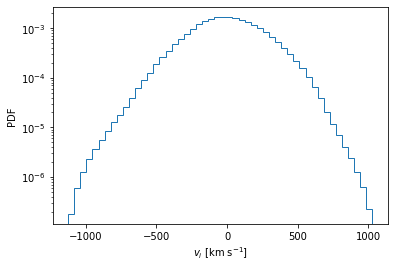

In [18]:
vel = psi*(f(zobs) * (1/(1+zobs)) * (100 * cosmo.efunc(zobs)))
plt.hist(vel.flatten(), bins=50, density=True, histtype='step', log=True)
plt.xlabel(r'$v_i$ [km s$^{-1}$]')
plt.ylabel('PDF')
# plt.savefig('vel_hist.pdf')

<ipython-input-36-4da291e85115>:21: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("jet").copy()
  cmap.set_under('w')


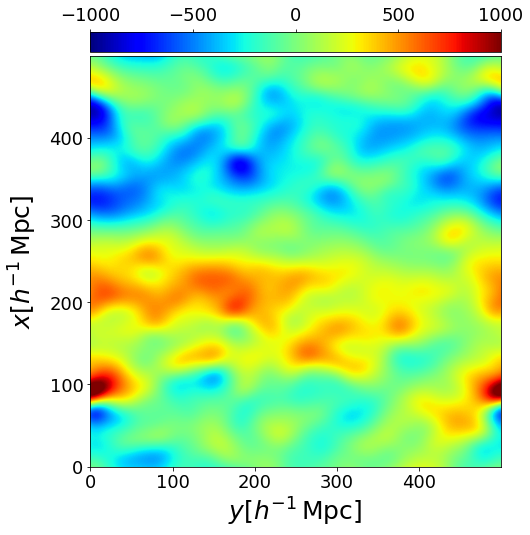

In [36]:
# Visualize velocity field
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)

start=0
end=1

c=vel[:,:,0,0]

c = scipy.ndimage.interpolation.zoom(c ,order=3, zoom=1)

def truncate_colormap(cmap, minval=-4.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
      'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
      cmap(np.linspace(minval, maxval, n)))
    return new_cmap

cmap = plt.get_cmap('bone_r')
cmap = plt.get_cmap('nipy_spectral')
cmap = plt.get_cmap('jet')
cmap.set_under('w')


im = plt.imshow(c,interpolation='bilinear',aspect='auto', extent=[0,Length,0,Length],cmap=cmap, vmin=-1000, vmax=1000)
plt.xlabel(r'$y[h^{-1}\,\mathrm{Mpc}]$',fontsize=25)
plt.ylabel(r'$x[h^{-1}\,\mathrm{Mpc}]$',fontsize=25, labelpad=10)

ax.set_aspect('equal')
plt.setp(ax.get_xticklabels(), fontsize=18)
plt.setp(ax.get_yticklabels(), fontsize=18)

divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("top", "5%", pad="1%")
cb = plt.colorbar(im,orientation='horizontal',cax=cax)
cb.ax.get_xaxis().labelpad = 0.
cb.ax.xaxis.set_tick_params(labelsize=18)
cb.ax.xaxis.set_ticks_position('top')

# plt.savefig('vel_map.pdf')

### Bias test

In [4]:
# expected bias from b(zinit) = (b(z0) - 1)D(zlow)/D(zhigh) + 1
bgzinit_e = (bg - 1)*(D(zobs)/D(zinit)) + 1
print('Expected b(z={:.2f}) = {:.2f}'.format(zinit, bgzinit_e))

Expected b(z=3.00) = 1.67


#### Test from $\tilde{\delta}_{\mathrm{DM}}$

In [20]:
# Extract bias post reconstruction
bgzinit = np.sqrt(np.mean(Pkgzinit[mask]*D(zobs)**2/(Pklin[mask]*D(zinit)**2)))
print('b(z={:.2f}) = {:.2f}'.format(zinit, bgzinit))

# Another method
# gzinit_corr = FFTCorr(delta_gzinit, mode='1d')
# bgzinit = np.nanmean((gzinit_corr.corr['corr']/dm_corr.corr['corr'])**(0.5))

b(z=3.00) = 3.74


#### Test from $\delta_{DM}$

In [21]:
delta_dm_s = delta_dm.apply(filters.Gaussian(r=r_s).filter, mode='complex', kind='wavenumber')
dispf = compute_zeld(Length, Nc, delta_dm_s.paint(mode='real'))

In [40]:
# maximum and minimum of displacement field
# print(dispf.min(), dispf.max(), dispf.std())

In [22]:
hod['Position_zinit_test'] = displace_galaxies(dispf, hod['PositionRSD'].compute(), Nc, Length, zinit=zinit, zobs=zobs)
delta_gzinit_test = hod.to_mesh(position='Position_zinit_test', resampler='cic', interlaced=True, compensated=True)

In [23]:
# Extract bias post reconstruction
r = FFTPower(delta_gzinit_test, mode="1d", Nmesh=Nc)
k = r.power['k']
# shot-noise from nbodykit
Pkgzinit_test = r.power['power'].real - r.attrs['shotnoise']

bgzinit = np.sqrt(np.mean(Pkgzinit_test[mask]*(D(zobs)**2)/(Pklin[mask]*(D(zinit)**2))))
print('b(z={:.2f}) = {:.2f}'.format(zinit, bgzinit))

# Another method
# gzinit_corr = FFTCorr(delta_gzinit, mode='1d')
# bgzinit = np.nanmean((gzinit_corr.corr['corr']/dm_corr.corr['corr'])**(0.5))

b(z=3.00) = 3.90


### Density field histograms

In [24]:
## Dark Matter
# pdf_dm = delta_dm.paint(mode='real')

## Galaxy pre-reconstruction
delta_g_s = delta_g.apply(filters.Gaussian(r=r_s).filter, mode='complex', kind='wavenumber')
pdf_g = delta_g_s.paint(mode='real')

## Galaxy post-reconstruction
delta_gzinit_s = delta_gzinit.apply(filters.Gaussian(r=r_s).filter, mode='complex', kind='wavenumber')
pdf_gzinit = delta_gzinit_s.paint(mode='real')

(0.0, 5.0)

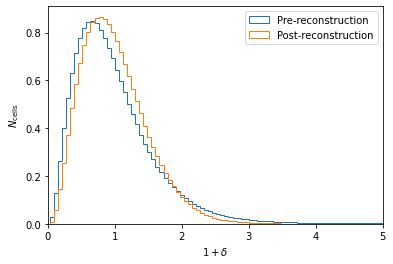

In [44]:
bins = numpy.linspace(-1, 5, 100)
plt.hist(pdf_g.value.flatten(), bins=bins, density=True, histtype='step', label='Pre-reconstruction')
plt.hist(pdf_gzinit.value.flatten(), bins=bins, density=True, histtype='step', label='Post-reconstruction')

# plt.hist(pdf_dm.value.flatten(), bins=bins, density=True, histtype='step', label='Dark matter')

# format the axes
plt.legend()
plt.xlabel(r"$1+\delta$")
plt.ylabel(r"$N_\mathrm{cells}$")
plt.xlim(0,5)

### Fast forward Zeldovich test

In [25]:
forward_displf = compute_zeld(Length, Nc, linear.paint(mode='real'))

/home/pcontreras/anaconda3/lib/python3.8/site-packages/nbodykit/source/mesh/linear.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  mask = numpy.bitwise_and.reduce([ki == 0 for ki in k])


In [26]:
def displace_particles(L, nc, vel):

    d1=L/float(nc)
    d2=d1
    d3=d1

    vx = vel[:,:,:,0]
    vy = vel[:,:,:,1]
    vz = vel[:,:,:,2]

    pos1d = np.zeros(nc**3*3)
    pos = pos1d.reshape(nc,nc,nc,3)
    posic=pos
    posn3 = pos1d.reshape(nc**3, 3)

    for i in range(nc):
      for j in range(nc):
        for k in range(nc):

          rx = 0.5*d1
          ry = 0.5*d2
          rz = 0.5*d3 

          xp = float(i)*d1+rx
          yp = float(j)*d2+ry
          zp = float(k)*d3+rz

          posic[i,j,k,0]=xp
          posic[i,j,k,1]=yp
          posic[i,j,k,2]=zp


          # if i==0:
          #   if j==0:
          #     if k==0:
                # print("check: x[0] = ", xp)

          xp += vx[i,j,k]
          yp += vy[i,j,k]
          zp += vz[i,j,k]

          # if i==0:
          #   if j==0:
          #     if k==0:
                # print("check: x[0]+Psi[0] = ", xp)

          per = True
          if per==True:
            if xp<0.:
              xp+=L
            if xp>=L:
              xp-=L

            if yp<0.:
              yp+=L
            if yp>=L:
             yp-=L

            if zp<0.:
              zp+=L
            if zp>=L:
              zp-=L

          pos[i,j,k,0]=xp
          pos[i,j,k,1]=yp
          pos[i,j,k,2]=zp

          l = k + j*(nc + i)
          posn3[l,0]=xp
          posn3[l,1]=yp
          posn3[l,2]=zp

    return pos, posn3

In [27]:
pos_mesh, pos_array = displace_particles(Length, Nc, forward_displf)

In [28]:
def cic_particles(L, nc, pos):

    d1=L/float(nc)
    d2=d1
    d3=d1

    dens1D=np.zeros(nc**3)
    dens=dens1D.reshape(nc,nc,nc)

    for iind in range(nc):
      for jind in range(nc):
        for kind in range(nc):

          xp=pos[iind,jind,kind,0]-0.5*d1
          yp=pos[iind,jind,kind,1]-0.5*d2
          zp=pos[iind,jind,kind,2]-0.5*d3

          if xp<0.:
            xp+=L
          if xp>=L:
            xp-=L

          if yp<0.:
            yp+=L
          if yp>=L:
            yp-=L

          if zp<0.:
            zp+=L
          if zp>=L:
            zp-=L

          i = int(np.floor(xp/d1))
          j = int(np.floor(yp/d2))
          k = int(np.floor(zp/d3))

          i = int(np.fmod(i, nc))
          j = int(np.fmod(j, nc))
          k = int(np.fmod(k, nc))

          ii = int(np.fmod(i+1, nc))
          jj = int(np.fmod(j+1, nc))
          kk = int(np.fmod(k+1, nc))

          xc = float(i)
          yc = float(j)
          zc = float(k)

          dx = xp/d1 - xc
          dy = yp/d2 - yc
          dz = zp/d3 - zc

          tx = 1. - dx
          ty = 1. - dy
          tz = 1. - dz

          dens[i,j,k]    += tx*ty*tz
          dens[ii,j,k]   += dx*ty*tz
          dens[i,jj,k]   += tx*dy*tz
          dens[i,j,kk]   += tx*ty*dz
          dens[ii,jj,k]  += dx*dy*tz
          dens[ii,j,kk]  += dx*ty*dz
          dens[i,jj,kk]  += tx*dy*dz
          dens[ii,jj,kk] += dx*dy*dz

    return dens

In [31]:
ww = np.ones(len(pos_array))
with open('dummy_file.dat', 'wb') as ff:
    pos_array.tofile(ff); ww.tofile(ff); ff.seek(0)

f = BinaryCatalog(ff.name, [('Position', ('f8', 3)), ('Mass', ('f8', 1))], size=len(pos_array))
dens_nb = f.to_mesh(Nmesh=Nc, BoxSize=Length, resampler='cic', interlaced=True, compensated=True)

/home/pcontreras/anaconda3/lib/python3.8/site-packages/nbodykit/io/binary.py:74: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  dtype = numpy.dtype(dtype)


In [29]:
dens_hc = cic_particles(Length, Nc, pos_mesh)

In [32]:
dens_nbmesh = ArrayMesh(dens_hc, Nmesh=Nc, BoxSize=Length)
r = FFTPower(dens_nbmesh, mode='1d')
Pkf_hc = r.power['power'].real - r.attrs['shotnoise']
r = FFTPower(dens_nb, mode='1d')
Pkf_nb = r.power['power'].real - r.attrs['shotnoise']

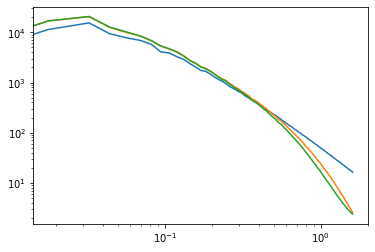

In [52]:
plt.loglog(k, Pklin)
plt.loglog(k, Pkf_nb)
plt.loglog(k, Pkf_hc)

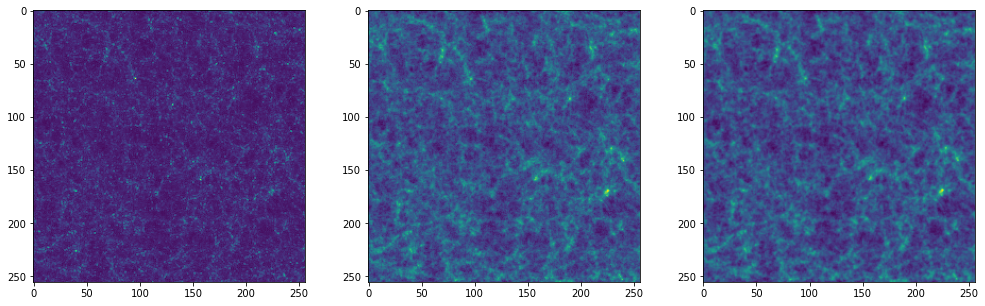

In [53]:
fig, ax = plt.subplots(1,3, figsize=(17,5))
ax[0].imshow(delta_dm.paint(mode='real').preview(axes=[0,1]))
ax[1].imshow(dens_nb.paint(mode='real').preview(axes=[0,1]))
ax[2].imshow(np.sum(dens_hc, axis=2))

## Save post reconstruction catalog celestial coordinates

In [54]:
# Compute celestial coordinates post-reconstruction
hod['SkyCoordz'] = transform.CartesianToSky(pos=hod['Position_zinit'], cosmo=cosmo, \
    observer=da.from_array([Length/2,Length/2,Length/2]), zmax=100., frame='icrs')
hod['SkyCoordzpec'] = transform.CartesianToSky(pos=hod['Position_zinit'], cosmo=cosmo, velocity=hod['Velocity'], \
    observer=da.from_array([Length/2,Length/2,Length/2]), zmax=100., frame='icrs')

# Save catalog
coord_array = np.zeros((ngal, 4))
coord_array[:, 0:3] = hod['SkyCoordz'].compute()
coord_array[:, 3] = hod['SkyCoordzpec'][:,2].compute()
mat = np.matrix(coord_array)
with open('cat_post_z0_z3.dat', 'wb') as ff:
    for line in mat:
        np.savetxt(ff, line, fmt='%.2f')

## Iteration

In [17]:
def field_interpolation(L, nc, psi, s):
    # tamano celda
    cellsize = L/nc
    # interpolamos el campo de velocidad en la malla a la posición de la galaxia
    psi_g = np.zeros_like(s)

    for i in range(len(psi_g)):
        j = int(np.floor(s[i, 0]/cellsize))
        k = int(np.floor(s[i, 1]/cellsize))
        l = int(np.floor(s[i, 2]/cellsize))

        j = int(np.fmod(j,nc))
        k = int(np.fmod(k,nc))
        l = int(np.fmod(l,nc))

        psi_g[i, 0] = psi[j, k, l, 0]
        psi_g[i, 1] = psi[j, k, l, 1]
        psi_g[i, 2] = psi[j, k, l, 2]

    return psi_g

def compute_vr(vel, q, observer, zobs):
    Omega_m = cosmology.Planck15.Omega_m(zobs)
    f = Omega_m**0.6   
    # deltaf = fft(delta)

    # vfx = deltaf.copy()
    # vfy = deltaf.copy()
    # vfz = deltaf.copy()
    
    # kfac = 2.0*np.pi/L
    
    # for i in range(nc):
    #     for j in range(nc):
    #         for k in range(nc):

    #             if i <= nc/2:
    #                 kx = kfac*np.float64(i)
    #             else:
    #                 kx = -kfac*np.float64(nc-i)
    #             if j <= nc/2:
    #                 ky = kfac*np.float64(j)
    #             else:
    #                 ky = -kfac*np.float64(nc-j)
    #             if k <= nc/2:
    #                 kz = kfac*np.float64(k)
    #             else:
    #                 kz = -kfac*np.float64(nc-k)

    #             kernelx = 0.
    #             kernely = 0.
    #             kernelz = 0.


    # # kernel: -nabla/nabla2 = i*kvec/k2 viene de: 
    # # d(exp(i*kvec*r))/dr=i*kvec  , d(exp(i*kvec*r))2/dr2=(i*kvec)*(i*kvec)=-k2 

    #             epsk = 1e-14
    #             if kx>epsk:
    #                 kernelx = (1/kx)*Kaiser
    #             if ky>epsk:
    #                 kernely = (1/ky)*Kaiser
    #             if kz>epsk:
    #                 kernelz = (1/kz)*Kaiser
                
    #             vfx.real[i,j,k] = -kernelx*deltaf.imag[i,j,k]
    #             vfx.imag[i,j,k] =  kernelx*deltaf.real[i,j,k]

    #             vfy.real[i,j,k] = -kernely*deltaf.imag[i,j,k]
    #             vfy.imag[i,j,k] =  kernely*deltaf.real[i,j,k]

    #             vfz.real[i,j,k] = -kernelz*deltaf.imag[i,j,k]
    #             vfz.imag[i,j,k] =  kernelz*deltaf.real[i,j,k]

    # vxg = ifft(vfx)
    # vx = vxg.real
    
    # vyg = ifft(vfy)
    # vy = vyg.real

    # vzg = ifft(vfz)
    # vz = vzg.real

    # vel1D = np.zeros(nc**3 * 3)
    # v_field   = vel1D.reshape(nc,nc,nc,3)

    # v_field[:,:,:,0] = vx
    # v_field[:,:,:,1] = vy
    # v_field[:,:,:,2] = vz

    #vel = field_interpolation(L, nc, v_field, q)
    position_origin = q - observer
    projection_norm = np.linalg.norm(position_origin, axis=1)
    line_of_sight = np.zeros_like(position_origin)
    line_of_sight = position_origin/projection_norm[:, np.newaxis]
    dot_prod = np.sum(vel*line_of_sight, axis=1)
    return f*dot_prod[:, np.newaxis]*line_of_sight
    
def compute_vrth(q, vel, observer, zobs):
    position_origin = q - observer
    projection_norm = np.linalg.norm(position_origin, axis=1)
    line_of_sight = np.zeros_like(position_origin)
    line_of_sight = position_origin/projection_norm[:, np.newaxis]
    rsd_factor = (1+zobs) / (100 * cosmo.efunc(zobs))
    dot_prod = np.sum(vel*line_of_sight, axis=1)
    return rsd_factor*dot_prod[:, np.newaxis]*line_of_sight

# def obtain_peculiarfield(k, v):
#     kk = sum(ki ** 2 for ki in k) # k^2 on the mesh
#     Omega_m = cosmology.Planck15.Omega_m(zobs)
#     Kaiser = Omega_m**0.6 /bg
#     return -(0 + 1j)/kk * Kaiser * v

In [47]:
def iteration(Niter, L, nc, zobs, zinit, cat, observer, k, Pkcomp):
    cat['PositionQ'] = cat['PositionRSD']
    s = cat['PositionRSD']
    q = cat['PositionQ']
    delta = cat.to_mesh(resampler='cic', position='PositionQ', interlaced=True, compensated=True)
    r = FFTPower(delta, mode='1d')
    Pk1 = r.power['power'].real - r.attrs['shotnoise']
    k1 = r.power['k']
    for i in range(Niter):
        fig, ax = plt.subplots(1, 1, figsize=(8,6))
        ax.loglog(k, Pkcomp, 'k', label='Pre reconstruction')

        psi = compute_zeld(L, nc, delta.apply(divide_bias, mode='real', kind='index')\
            .apply(filters.Gaussian(r=r_s).filter, mode='complex', kind='wavenumber').compute(mode='real'))
        psi_g = field_interpolation(L, nc, psi, q.compute())
        vr = compute_vr((D(zobs)-D(zinit))*psi_g, q.compute(), observer, zobs)
        
        cat['PositionQ'] = s - (D(zobs)-D(zinit))*psi_g - vr # Iteration 1st step: q' = s - Psi(q) - vr(q)
        # q = s - psi - vr
        
        q = cat['PositionQ']
        delta = cat.to_mesh(resampler='cic', position='PositionQ', interlaced=True, compensated=True)
        r = FFTPower(delta, mode='1d')
        Pk2 = r.power['power'].real - r.attrs['shotnoise']
        k2 = r.power['k']
        ax.loglog(k1, Pk1, label='Iteration {:1n}'.format(i))
        ax.loglog(k2, Pk2, ':', label='Iteration {:1n}'.format(i+1))
        ax.legend()
        ax.set_xlabel(r'$k [\mathrm{h Mpc}^{-1}]$', fontsize=18)
        ax.set_ylabel(r'$P(k)$ $[h^{-3} \mathrm{Mpc}^3]$', fontsize=18)
        ax.tick_params(axis='both', which='major', labelsize=14)
        plt.tight_layout()
        plt.show()
        #plt.savefig('Pkcomparison_iter{:1d}_paired'.format(i+1)+str(paired)+'.pdf')
        
        print('Iteration {:1d}, Mean difference between Pks: {:.2f}'.format(i+1, np.mean(abs(Pk1 - Pk2))))

        Pk1 = Pk2
    
    qprime = cat['PositionQ']
    deltaQ = cat.to_mesh(resampler='cic', position='PositionQ', interlaced=True, compensated=True)
    psi = compute_zeld(L, nc, deltaQ.apply(divide_bias, mode='real', kind='index')\
        .apply(filters.Gaussian(r=r_s).filter, mode='complex', kind='wavenumber').compute(mode='real'))
    psi_g = field_interpolation(L, nc, psi, qprime.compute())
    
    cat['PositionQS'] = s - (D(zobs) - D(zinit))*psi_g # Iteration 2nd step: qs = s - Psi(q')
    deltaQS = cat.to_mesh(resampler='cic', position='PositionQS', interlaced=True, compensated=True)
    return deltaQ, deltaQS

In [31]:
compute_vrth(halos['PositionQ'], halos['Velocity'], [Length/2, Length/2, Length/2], zobs)[:3].compute()

array([[-1.03320459, -1.2428564 ,  1.16717373],
       [-1.70754829,  1.60698464, -0.55224602],
       [-1.13831035, -0.55126527, -2.0636072 ]])

In [50]:
delta = halos.to_mesh(resampler='cic', position='PositionQ', interlaced=True, compensated=True)
psi = compute_zeld(Length, Nc, delta.apply(divide_bias, mode='real', kind='index')\
            .apply(filters.Gaussian(r=r_s).filter, mode='complex', kind='wavenumber').paint(mode='real'))
psi_g = field_interpolation(Length, Nc, psi, halos['PositionQ'].compute())
vr = compute_vr((D(zobs)-D(zinit))*psi_g, halos['PositionQ'], [Length/2, Length/2, Length/2], zobs)

halos['Positionzinit'] = halos['PositionQS'] - vr
delta = halos.to_mesh(resampler='cic', position='Positionzinit', interlaced=True, compensated=True)
r = FFTPower(delta, mode="1d", Nmesh=Nc)
Pkhrecons = r.power['power'].real - r.attrs['shotnoise']
bgrecons = np.mean(np.sqrt(Pkhrecons[mask]*(D(zobs)**2)/(Pkdm[mask]*(D(zinit)**2))))

In [51]:
delta = halos.to_mesh(resampler='cic', position='PositionQ', interlaced=True, compensated=True)
r = FFTPower(delta, mode="1d", Nmesh=Nc)
Pkhrecons = r.power['power'].real - r.attrs['shotnoise']
bgrecons = np.mean(np.sqrt(Pkhrecons[mask]*(D(zobs)**2)/(Pkdm[mask]*(D(zinit)**2))))
bgrecons

5.164155304468659

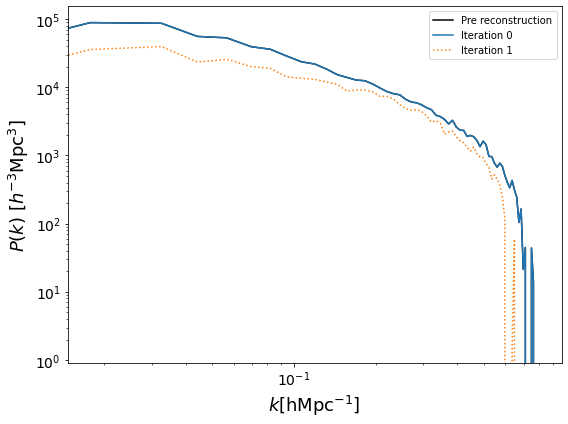

Iteration 1, Mean difference between Pks: 4508.45


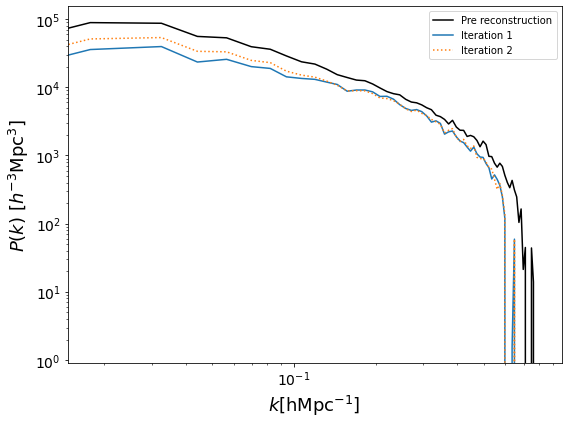

Iteration 2, Mean difference between Pks: 1058.80


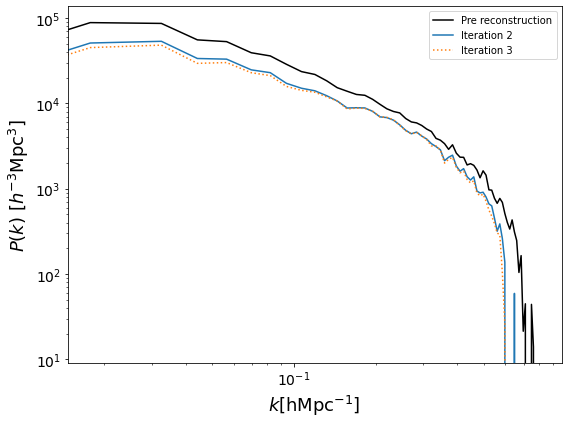

Iteration 3, Mean difference between Pks: 463.79


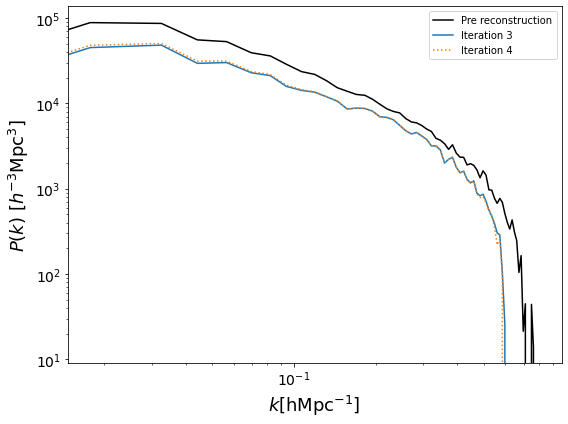

Iteration 4, Mean difference between Pks: 199.52


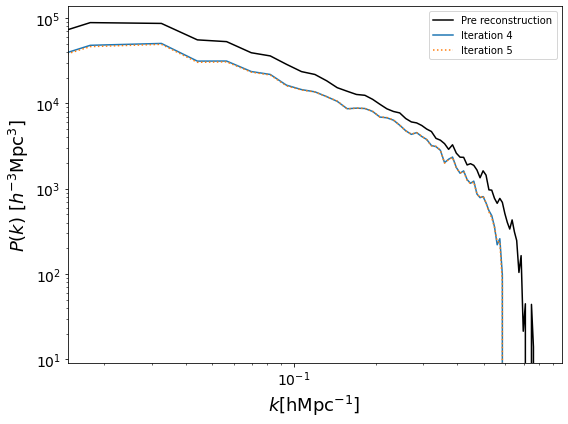

Iteration 5, Mean difference between Pks: 104.91
bias (redshift) halos POST= 5.50(z=3.00),2.04(z=0.30)
bias (real) halos POST= 5.16(z=3.00),1.92(z=0.30)


In [48]:
reconstructedQ, reconstructedQS = iteration(5, Length, Nc, zobs, zinit, halos, [Length/2, Length/2, Length/2], k, PkhalosRSD)

r = FFTPower(reconstructedQS, mode="1d", Nmesh=Nc)
Pkhrecons = r.power['power'].real - r.attrs['shotnoise']

bgrecons = np.mean(np.sqrt(Pkhrecons[mask]*(D(zobs)**2)/(Pkdm[mask]*(D(zinit)**2))))

bgrecons2 = np.mean(np.sqrt(Pkhrecons[mask]/Pkdm[mask]))

print('bias (redshift) halos POST= {:.2f}(z={:.2f}),{:.2f}(z={:.2f})'.format(bgrecons, zinit,bgrecons2, zobs))

r = FFTPower(reconstructedQ, mode="1d", Nmesh=Nc)
Pkhreconr = r.power['power'].real - r.attrs['shotnoise']
bgreconr = np.mean(np.sqrt(Pkhreconr[mask]*(D(zobs)**2)/(Pkdm[mask]*(D(zinit)**2))))

bgreconr2 = np.mean(np.sqrt(Pkhreconr[mask]/Pkdm[mask]))
print('bias (real) halos POST= {:.2f}(z={:.2f}),{:.2f}(z={:.2f})'.format(bgreconr, zinit,bgreconr2, zobs))

In [49]:
bg

2.2745888610689886

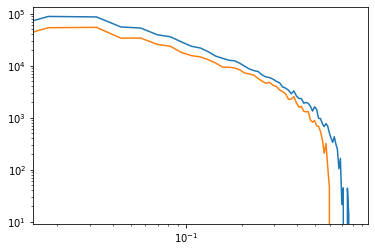

In [22]:
r = FFTPower(reconstructed, mode="1d", Nmesh=Nc)
# shot-noise from nbodykit
Pkhrecon = r.power['power'].real - r.attrs['shotnoise']
plt.loglog(k, PkhalosRSD)
plt.loglog(k, Pkhrecon)

Text(0.5, 1.0, 'Post-reconstruction 2')

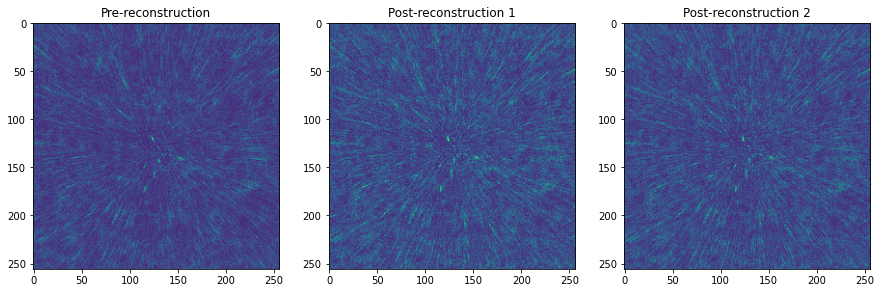

In [55]:
fig, ax = plt.subplots(1, 3, figsize=(15,5))
ax[0].imshow(delta_gRSD.paint(mode='real').preview(axes=[0,1]))
ax[0].set_title('Pre-reconstruction')
ax[1].imshow(delta_gzinit.paint(mode='real').preview(axes=[0,1]))
ax[1].set_title('Post-reconstruction 1')
ax[2].imshow(reconstructed.paint(mode='real').preview(axes=[0,1]))
ax[2].set_title('Post-reconstruction 2')

4.055584338450633


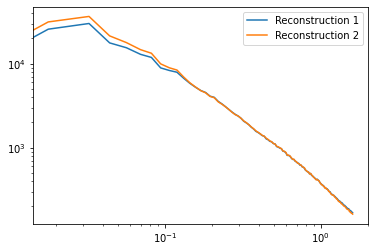

In [56]:
r = FFTPower(reconstructed, mode="1d", Nmesh=Nc)
# shot-noise from nbodykit
Pkgrecon = r.power['power'].real - r.attrs['shotnoise']

plt.loglog(k, Pkgzinit, label='Reconstruction 1')
plt.loglog(k, Pkgrecon, label='Reconstruction 2')
plt.legend()

bgtest = np.mean(np.sqrt(Pkgrecon[mask]*(D(zobs)**2)/(Pklin[mask]*(D(zinit)**2))))
print(bgtest)

# Reconstruction on Halos

In [12]:
# move halos to redshift space

## RSD formula
# vr = 1/(Ha) * (vec(v).vec(r_unit))vec(r_unit)

## Box centered
position_origin = halos['Position'] - 0.5*Length

projection_norm = np.linalg.norm(position_origin, axis=1)

line_of_sight = np.zeros_like(position_origin)
line_of_sight = position_origin/projection_norm[:, np.newaxis]

rsd_factor = (1+zobs) / (100 * cosmo.efunc(zobs))

dot_prod = np.sum(halos['Velocity']*line_of_sight, axis=1)

halos['PositionRSD'] = position_origin + rsd_factor*dot_prod[:, np.newaxis]*line_of_sight + 0.5*Length


In [13]:
# Bias from halos PRE
bg = np.mean(np.sqrt(Pkhalos[mask]/Pklin[mask]))
# bhalos2  = np.mean(np.sqrt(Pkhalos[mask]/(D(zobs)**2 * Plin0[mask])))

print('bias halos PRE= {:.2f}'.format(bg))

bias halos PRE= 2.27


In [11]:
def divide_biashalos(x, v):
    return v/bhalos

# delta_hRSD = halos.to_mesh(position='PositionRSD', resampler='cic', interlaced=True, compensated=True)

# delta_halos = delta_hRSD.apply(divide_biashalos, mode='real', kind='index')

# delta_dm_tilde = delta_halos.apply(filters.Gaussian(r=r_s).filter, mode='complex', kind='wavenumber')

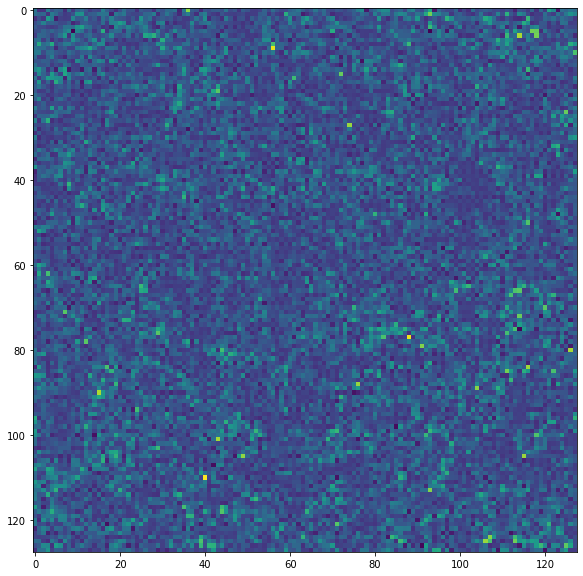

In [43]:
delta_hRSD = halos.to_mesh(position='PositionRSD', resampler='cic', interlaced=True, compensated=True)
fig = plt.figure(figsize=(10,10))
plt.imshow(delta_hRSD.paint(mode='real').preview(axes=[0,1]))

In [13]:
delta_hRSD = halos.to_mesh(position='PositionRSD', resampler='cic', interlaced=True, compensated=True)
psi = compute_zeld(Length, Nc, delta_hRSD.apply(divide_biashalos, mode='real', kind='index').apply(filters.Gaussian(r=r_s).filter, mode='complex', kind='wavenumber').paint(mode='real'))
halos['Position_zinit'] = displace_galaxies(psi, halos['PositionRSD'].compute(), Nc, Length, zinit=zinit, zobs=zobs)
delta_haloszinit = halos.to_mesh(position='Position_zinit', resampler='cic', interlaced=True, compensated=True)

In [45]:
r = FFTPower(delta_hRSD, mode='1d', Nmesh=Nc)
PkhalosRSD = r.power['power'].real - r.attrs['shotnoise']

# r = FFTPower(delta_haloszinit, mode='1d', Nmesh=Nc)
# Pkhaloszinit = r.power['power'].real - r.attrs['shotnoise']

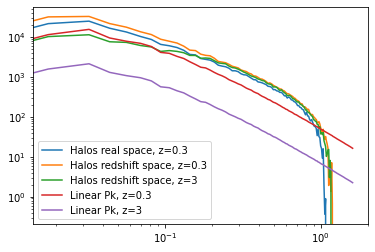

In [15]:
plt.loglog(k, Pkhalos, label='Halos real space, z=0.3')
plt.loglog(k, PkhalosRSD, label='Halos redshift space, z=0.3')
plt.loglog(k, Pkhaloszinit, label='Halos redshift space, z=3')
plt.loglog(k, Pklin, label='Linear Pk, z=0.3')
plt.loglog(k, Pklin*(D(zinit)/D(zobs))**2, label='Linear Pk, z=3')
plt.legend()

In [16]:
# expected bias from b(zinit) = (b(z0) - 1)D(zlow)/D(zhigh) + 1
#bhzinit_e = (bhalos - 1)*(D(zobs)/D(zinit)) + 1
#print('Expected b(z={:.2f}) = {:.2f}'.format(zinit, bhzinit_e))

# Bias from halos POST
bhalosinit = np.mean(np.sqrt(Pkhaloszinit[mask]*(D(zobs)**2)/(Pklin[mask]*(D(zinit)**2))))
# bhalos2  = np.mean(np.sqrt(Pkhalos[mask]/(D(zobs)**2 * Plin0[mask])))

bhalosinit2 = np.mean(np.sqrt(Pkhaloszinit[mask]/Pklin[mask]))

print('bias halos POST= {:.2f},{:.2f}'.format(bhalosinit,bhalosinit2))

bias halos POST= 2.47,0.91


In [84]:
dispf = compute_zeld(Length, Nc, delta_dm_s.paint(mode='real'))
halos['Position_zinit_test'] = displace_galaxies(dispf, halos['PositionRSD'].compute(), Nc, Length, zinit=zinit, zobs=zobs)
delta_hzinit_test = halos.to_mesh(position='Position_zinit_test', resampler='cic', interlaced=True, compensated=True)

r = FFTPower(delta_hzinit_test, mode='1d', Nmesh=Nc)
Pkhalostest = r.power['power'].real - r.attrs['shotnoise']
bhalosinitest = np.mean(np.sqrt(Pkhalostest[mask]*(D(zobs)**2)/(Pklin[mask]*(D(zinit)**2))))

print('bias halos POST= {:.2f}'.format(bhalosinitest))

bias halos POST= 2.58


# Comparison

In [17]:
# sprime = s - psi(s) iterative
# s2prime = s - psi(sprime)
def iteration_s(Niter, L, nc, zobs, zinit, cat, k, Pkcomp):
    s = cat['PositionRSD']
    cat['PositionSp'] = cat['PositionRSD']
    Sp = cat['PositionSp']
    delta = cat.to_mesh(resampler='cic', position='PositionSp', interlaced=True, compensated=True)
    r = FFTPower(delta, mode='1d')
    Pk1 = r.power['power'].real - r.attrs['shotnoise']
    k1 = r.power['k']
    for i in range(Niter):
        plt.loglog(k, Pkcomp, 'k', label=r'$P_{\mathrm{lin}}(z=0.3)$')

        psi = compute_zeld(L, nc, delta.apply(divide_biashalos, mode='real', kind='index')\
            .apply(filters.Gaussian(r=r_s).filter, mode='complex', kind='wavenumber').paint(mode='real'))
        psi_g = field_interpolation(L, nc, psi, Sp.compute())
        
        # sp = s - psi(s)
        cat['PositionSp'] = s - (D(zobs) - D(zinit))*psi_g
        Sp = cat['PositionSp']
        delta = cat.to_mesh(resampler='cic', position='PositionSp', interlaced=True, compensated=True)
        
        r = FFTPower(delta, mode='1d')
        Pk2 = r.power['power'].real - r.attrs['shotnoise']
        k2 = r.power['k']
        plt.loglog(k1, Pk1, label='Iteration {:1n}'.format(i))
        plt.loglog(k2, Pk2, label='Iteration {:1n}'.format(i+1))
        plt.legend()
        plt.xlabel(r'$k\ [\mathrm{h Mpc}^{-1}]$')
        plt.ylabel(r'$P(k, z)$ $[h^{-3} \mathrm{Mpc}^3]$')
        plt.show()
        
        print('Iteration {:2d}: Mean difference between Pks: {:.2f}'.format(i+1, np.mean(abs(Pk1 - Pk2))))
        
        Pk1 = Pk2
    return delta

In [18]:
# qprime = r - psi(r) iterative
# q2prime = r - psi(qprime)
def iteration_r(Niter, L, nc, zobs, zinit, cat, k, Pkcomp):
    R = cat['Position']
    cat['PositionQp'] = cat['Position']
    Qp = cat['PositionQp']
    delta = cat.to_mesh(resampler='cic', position='PositionQp', interlaced=True, compensated=True)
    r = FFTPower(delta, mode='1d')
    Pk1 = r.power['power'].real - r.attrs['shotnoise']
    k1 = r.power['k']
    for i in range(Niter):
        plt.loglog(k, Pkcomp, 'k', label=r'$P_{\mathrm{lin}}(z=0.3)$')

        psi = compute_zeld(L, nc, delta.apply(divide_biashalos, mode='real', kind='index')\
            .apply(filters.Gaussian(r=r_s).filter, mode='complex', kind='wavenumber').paint(mode='real'))
        psi_g = field_interpolation(L, nc, psi, Qp.compute())
        
        # Qp = R - psi(R)
        cat['PositionQp'] = R - (D(zobs) - D(zinit))*psi_g
        Qp = cat['PositionQp']
        delta = cat.to_mesh(resampler='cic', position='PositionQp', interlaced=True, compensated=True)
        
        r = FFTPower(delta, mode='1d')
        Pk2 = r.power['power'].real - r.attrs['shotnoise']
        k2 = r.power['k']
        plt.loglog(k1, Pk1, label='Iteration {:1n}'.format(i))
        plt.loglog(k2, Pk2, label='Iteration {:1n}'.format(i+1))
        plt.legend()
        plt.xlabel(r'$k\ [\mathrm{h Mpc}^{-1}]$')
        plt.ylabel(r'$P(k, z)$ $[h^{-3} \mathrm{Mpc}^3]$')
        plt.show()
        
        print('Iteration {:2d}: Mean difference between Pks: {:.2f}'.format(i+1, np.mean(abs(Pk1 - Pk2))))

        Pk1 = Pk2
    return delta

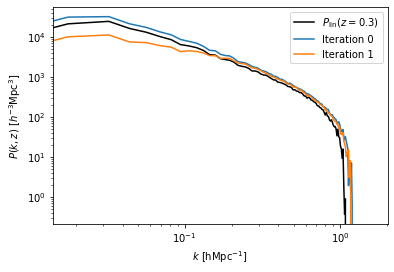

Iteration  1: Mean difference between Pks: 780.99


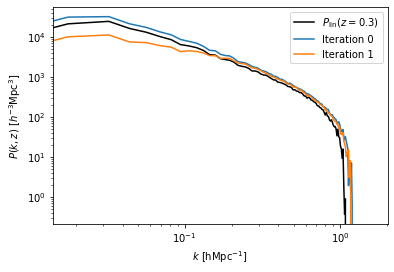

Iteration  1: Mean difference between Pks: 780.99


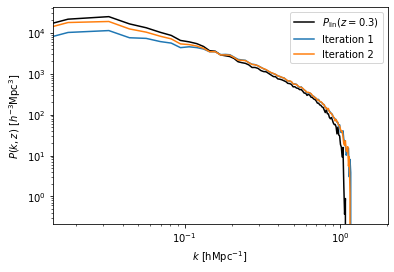

Iteration  2: Mean difference between Pks: 233.93


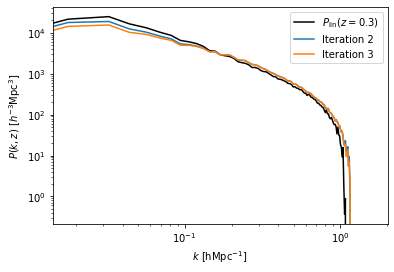

Iteration  3: Mean difference between Pks: 100.29


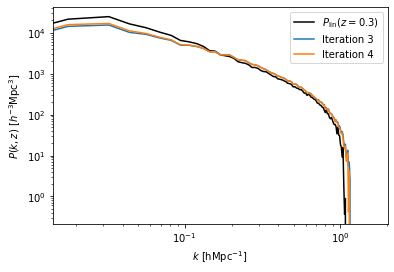

Iteration  4: Mean difference between Pks: 42.61


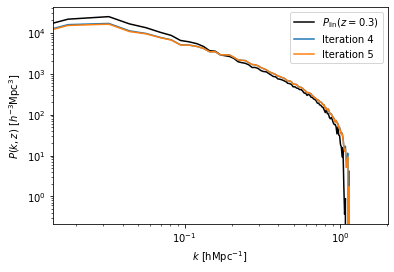

Iteration  5: Mean difference between Pks: 19.77


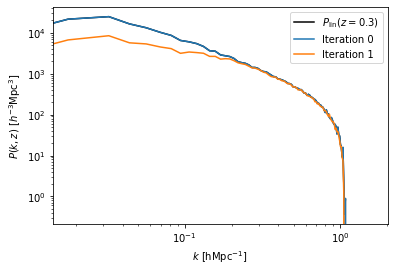

Iteration  1: Mean difference between Pks: 584.39


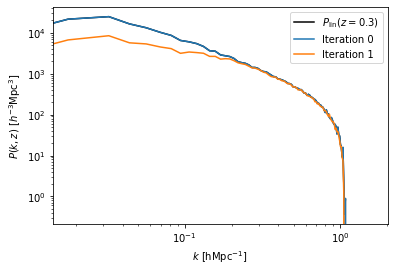

Iteration  1: Mean difference between Pks: 584.39


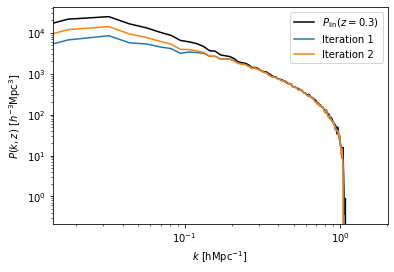

Iteration  2: Mean difference between Pks: 174.93


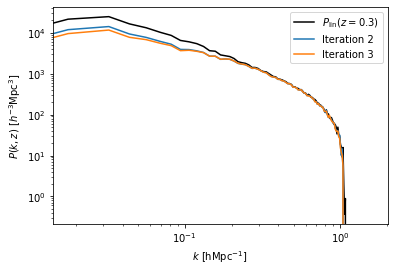

Iteration  3: Mean difference between Pks: 72.64


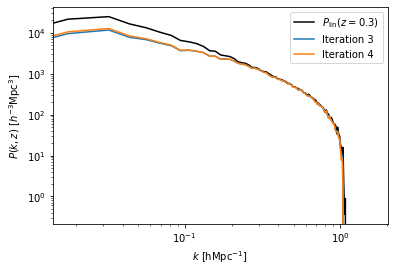

Iteration  4: Mean difference between Pks: 30.50


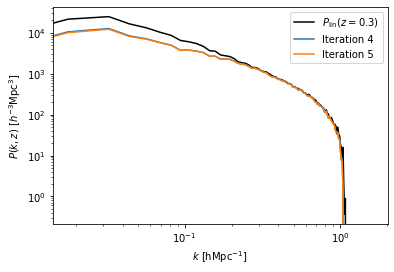

Iteration  5: Mean difference between Pks: 13.47


In [21]:
deltaS1p = iteration_s(1, Length, Nc, zobs, zinit, halos, k, Pkhalos)
deltaS5p = iteration_s(5, Length, Nc, zobs, zinit, halos, k, Pkhalos)
deltaQ1p = iteration_r(1, Length, Nc, zobs, zinit, halos, k, Pkhalos)
deltaQ5p = iteration_r(5, Length, Nc, zobs, zinit, halos, k, Pkhalos)

In [22]:
r = FFTPower(deltaS1p, mode='1d', Nmesh=Nc)
PkS1p = r.power['power'].real - r.attrs['shotnoise']

r = FFTPower(deltaS5p, mode='1d', Nmesh=Nc)
PkS5p = r.power['power'].real - r.attrs['shotnoise']

r = FFTPower(deltaQ1p, mode='1d', Nmesh=Nc)
PkQ1p = r.power['power'].real - r.attrs['shotnoise']

r = FFTPower(deltaQ5p, mode='1d', Nmesh=Nc)
PkQ5p = r.power['power'].real - r.attrs['shotnoise']

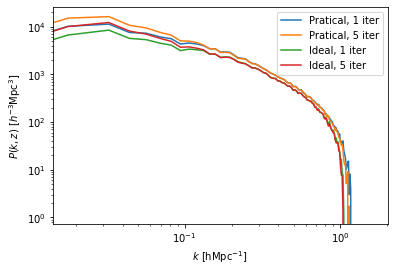

In [23]:
plt.loglog(k, PkS1p, label='Pratical, 1 iter')
plt.loglog(k, PkS5p, label='Pratical, 5 iter')
plt.loglog(k, PkQ1p, label='Ideal, 1 iter')
plt.loglog(k, PkQ5p, label='Ideal, 5 iter')
plt.legend()
plt.xlabel(r'$k\ [\mathrm{h Mpc}^{-1}]$')
plt.ylabel(r'$P(k, z)$ $[h^{-3} \mathrm{Mpc}^3]$')
plt.savefig('Comparison_iterative.pdf')